In [1]:
import numpy as np
from scipy.integrate import ode as ODE
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_probability as tfp

tfd = tfp.distributions

In [75]:
class TransitionDynamics:
    
    def __init__(self, hidden_size, state_size):
        
        self.W1 = np.random.normal(size=(hidden_size, state_size), loc=0, scale=state_size**-0.5)
        self.b1 = np.random.normal(size=(hidden_size,))
        
        self.W2 = np.random.normal(size=(state_size, hidden_size), loc=0, scale=hidden_size**-0.5)
        self.b2 = np.random.normal(size=(state_size,))
        
    
    def __call__(self, t, x):
        
        assert len(x.shape) == 1
        
        x = np.dot(self.W1, x)
        x = x + self.b1
        
        x = np.tanh(x)
        
        x = np.dot(self.W2, x)
        x = x + self.b2
        
        return x

In [76]:
np.random.seed(0)

transition_dynamics = TransitionDynamics(hidden_size=3, state_size=2)

x = np.zeros(shape=(2,))

transition_dynamics(None, x)

array([0.41020533, 1.78223644])

In [77]:
np.random.seed(0)

transition_dynamics = TransitionDynamics(hidden_size=3, state_size=2)

y0 = np.array([0., 0.])
t0 = 0.
t1 = 1.

ode = ODE(f=transition_dynamics.__call__).set_integrator('vode')
ode = ode.set_initial_value(y0, t0)

ode.integrate(t1)

array([0.2111968, 1.8093717])

/Users/stratis/repos/random-walks/venv-random-walks/lib/python3.7/site-packages/scipy/integrate/_ode.py:1009: UserWarning: vode: Illegal input detected. (See printed message.)
  self.messages.get(istate, unexpected_istate_msg)))
/Users/stratis/repos/random-walks/venv-random-walks/lib/python3.7/site-packages/scipy/integrate/_ode.py:1009: UserWarning: vode: Illegal input detected. (See printed message.)
  self.messages.get(istate, unexpected_istate_msg)))
/Users/stratis/repos/random-walks/venv-random-walks/lib/python3.7/site-packages/scipy/integrate/_ode.py:1009: UserWarning: vode: Illegal input detected. (See printed message.)
  self.messages.get(istate, unexpected_istate_msg)))
/Users/stratis/repos/random-walks/venv-random-walks/lib/python3.7/site-packages/scipy/integrate/_ode.py:1009: UserWarning: vode: Illegal input detected. (See printed message.)
  self.messages.get(istate, unexpected_istate_msg)))
/Users/stratis/repos/random-walks/venv-random-walks/lib/python3.7/site-packages/scip

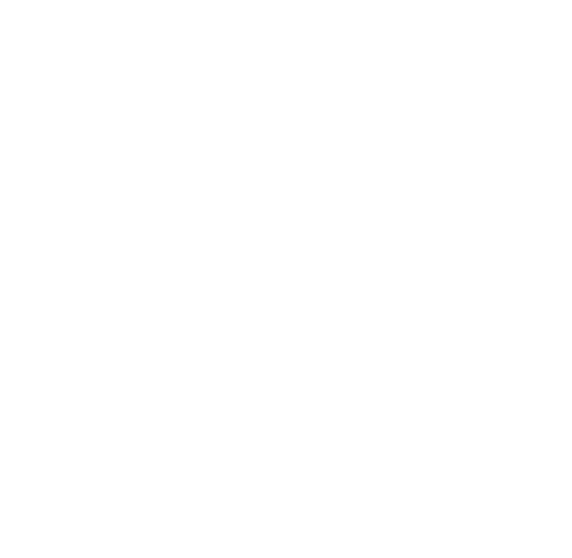

In [79]:
t0 = 0.
t1 = 10.
num_seeds = 100
dt = t1 / 50

plt.figure(figsize=(10, 10))

for i in range(9):

    transition_dynamics = TransitionDynamics(hidden_size=3, state_size=2)

    times = []
    states = []

    for seed in range(num_seeds):

        times.append([])
        states.append([])

        y0 = 4 * (np.random.rand(2) - 0.5)

        ode = ODE(f=transition_dynamics.__call__).set_integrator('vode')
        ode = ode.set_initial_value(y0, t0)

        while ode.successful() and ode.t < t1:

            times[-1].append(ode.t + dt)
            states[-1].append(ode.integrate(ode.t + dt))

    times = np.array(times)
    states = np.array(states)

    plt.subplot(3, 3, i + 1)

    # Plot trajectories
    for seed in range(num_seeds):
        plt.plot(states[seed, :, 0], states[seed, :, 1], color='blue', alpha=0.5)
    
    plt.axis('off')
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    
plt.show()

In [68]:
class NODEModel(tfk.Model):
    
    def __init__(self, hidden_size, state_size, name='transition-dynamics', dtype=tf.float64, **kwargs):
        
        super().__init__(self, name=name, dtype=dtype, **kwargs)
        
        self.state_size = state_size
        
        self.W1 = tf.random.normal(shape=(hidden_size, state_size),
                                   mean=0.,
                                   stddev=state_size**-0.5,
                                   dtype=dtype)
        self.W1 = tf.Variable(self.W1)
        
        self.b1 = tf.random.normal(shape=(hidden_size,),
                                   mean=0.,
                                   stddev=1.,
                                   dtype=dtype)
        self.b1 = tf.Variable(self.b1)
        
        self.W2 = tf.random.normal(shape=(state_size, hidden_size),
                                   mean=0,
                                   stddev=hidden_size**-0.5,
                                   dtype=dtype)
        self.W2 = tf.Variable(self.W2)
        
        self.b2 = tf.random.normal(shape=(state_size,),
                                   mean=0.,
                                   stddev=1.,
                                   dtype=dtype)
        self.b2 = tf.Variable(self.b2)
        
        self.log_noise = tf.convert_to_tensor(np.array(-1.), dtype=dtype)
        self.log_noise = tf.Variable(self.log_noise)
        
    
    def __call__(self, t, x):
        
        assert len(x.shape) == 1
        
        x = tf.tensordot(self.W1, x, axes=(1, 0))
        x = x + self.b1
        
        x = tf.tanh(x)
        
        x = tf.tensordot(self.W2, x, axes=(1, 0))
        x = x + self.b2
        
        return x
    
    
    def df_dx(self, t, x):
        
        with tf.GradientTape() as tape:
            
            tape.watch(x)
            
            f = self.__call__(t, x)
            
        df_dx = tape.gradient(f, x)
        
        return df_dx
    
    
    def df_dtheta(self, t, x):
        
        with tf.GradientTape() as tape:
            
            tape.watch(self.variables)
            
            f = self.__call__(t, x)
            
        df_dtheta = tape.gradient(f, self.variables)
        
        return df_dtheta
    
    
    def loglik(self, x_pred, x_data):
        """
        params x_pred : tf.tensor, predicted state (shape [batch_size, state_size])
        params x_data : tf.tensor, data state (shape [batch_size, state_size])
        """
        
        assert x_pred.shape == x_data.shape
        assert x_pred.shape[-1] == self.state_size
        
        dist = tfd.MultivariateNormalDiag(loc=tf.convert_to_tensor(x_pred, dtype=tf.float32),
                                          scale_identity_multiplier=tf.exp(self.log_noise))
        
        loglik = dist.log_prob(x_data)
        loglik = tf.reduce_sum(loglik)
        
        return loglik
    
    
    def dL_dx(self, x_pred, x_data):
        
        with tf.GradientTape() as tape:
            
            tape.watch(x_pred)
            
            L = - self.loglik(x_pred=x_pred, x_data=x_data)
            
        dL_dx = tape.gradient(L, x_pred)
        
        return dL_dx

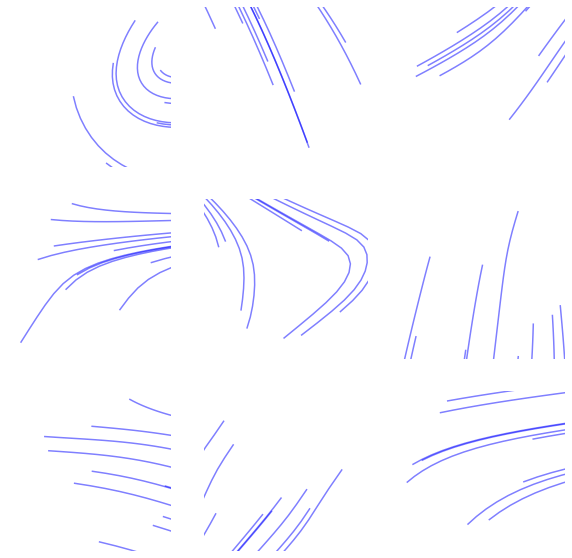

In [69]:
dtype = tf.float32

t0 = 0.
t1 = 10.
num_seeds = 10
dt = t1 / 50

plt.figure(figsize=(10, 10))

for i in range(9):

    node_model = NODEModel(hidden_size=3, state_size=2, dtype=dtype)

    times = []
    states = []

    for seed in range(num_seeds):

        times.append([])
        states.append([])

        y0 = 4 * (np.random.rand(2) - 0.5)
        
        def f(t, x):
            
            x = tf.convert_to_tensor(x, dtype=dtype)
            
            z = node_model(t=t, x=x)
            z = z.numpy()
            
            return z
            
        ode = ODE(f=f).set_integrator('vode')
        ode = ode.set_initial_value(y0, t0)

        while ode.successful() and ode.t < t1:

            times[-1].append(ode.t + dt)
            states[-1].append(ode.integrate(ode.t + dt))

    times = np.array(times)
    states = np.array(states)

    plt.subplot(3, 3, i + 1)

    # Plot trajectories
    for seed in range(num_seeds):
        plt.plot(states[seed, :, 0], states[seed, :, 1], color='blue', alpha=0.5)
    
    plt.axis('off')
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    
plt.show()

In [70]:
x = tf.random.normal(shape=(2,), mean=0., stddev=1., dtype=tf.float32)

node_model.df_dx(t=None, x=x)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.3024133 , 0.10968729], dtype=float32)>

In [71]:
x = tf.random.normal(shape=(2,), mean=0., stddev=1., dtype=tf.float32)

node_model.df_dtheta(t=None, x=x)

[<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[ 0.18246157,  0.10949817],
        [-0.12920731, -0.07753941],
        [ 0.05073825,  0.03044885]], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.18828529, -0.13333128,  0.05235768], dtype=float32)>,
 <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
 array([[0.7109098, 0.6820052, 0.9677044],
        [0.7109098, 0.6820052, 0.9677044]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>,
 None]

In [72]:
dist = tfd.MultivariateNormalDiag(loc=tf.zeros(shape=(10, 1), dtype=tf.float32), scale_identity_multiplier=1.)
dist.log_prob(tf.zeros(shape=(10, 1), dtype=tf.float32))

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-0.9189385, -0.9189385, -0.9189385, -0.9189385, -0.9189385,
       -0.9189385, -0.9189385, -0.9189385, -0.9189385, -0.9189385],
      dtype=float32)>

In [73]:
dist

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[10] event_shape=[1] dtype=float32>

In [74]:
2 * np.log((2 * np.pi) ** -0.5)

-1.8378770664093453

In [75]:
node_model.loglik(x_pred=tf.zeros((5, 2)),
                  x_data=tf.zeros((5, 2)))

<tf.Tensor: shape=(), dtype=float32, numpy=0.8106148>

In [86]:
node_model.dL_dx(x_pred=tf.ones((1, 2)),
                 x_data=tf.zeros((1, 2)))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[7.3890557, 7.3890557]], dtype=float32)>

In [87]:
1 * np.exp(2)

7.38905609893065